In [6]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns

#data frame with t, id
def matrix_life_mask(times,max_time):
    ar = np.zeros(max_time)
    ar[times] = 1
    return ar

def make_life_mat(df):
    maxt = df.t.dropna().max()+1
    index = []
    mat = []
    for k,g in df.groupby("key"):
        l = list(g.t.dropna().values)
        vals = matrix_life_mask(l, maxt)
        index.append(k)
        mat.append(vals)
    return pd.DataFrame(mat, index=index)

def make_fluc_mat(df):
    return df[["epsilon", "key", "t"]].groupby(["t", "key"])[["epsilon"]].\
    mean().reset_index().pivot("key", "t", "epsilon").fillna(0)

In [8]:
df=pd.read_csv("../cached_data/augmented.txt")
df.t =df.t+1

fluc_mat = make_fluc_mat(df)
life_mat = make_life_mat(df)

bandd = life_mat.diff(1,axis=1,).fillna(0) #* lifetime_matrix
births = bandd[bandd==1].fillna(0)
deaths = np.abs(bandd[bandd==-1]).fillna(0)
ageMat = life_mat.cumsum(axis=1) * life_mat

In [9]:
life_mat.to_csv("../cached_data/lifemat.txt",index=None)

In [3]:
ageMat

,0,1,2,3,4,5,6,7,8,9,...,440,441,442,443,444,445,446,447,448,449
0,0.0,1.0,2.0,3.0,4.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,2.0,3.0,4.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,2.0,3.0,4.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,2.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,1.0,2.0,3.0,4.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,1.0,2.0,3.0,4.0,5.0,6.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,1.0,2.0,3.0,4.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [60]:
chk=df[20:].reset_index().drop("Unnamed: 0",1).drop("s", 1).drop("level_0",1).drop("index",1)
chk.epsilon = chk.epsilon.fillna(0).round(4)
chk[["key","t", "x", "y", "z", "epsilon"]].to_csv("raw.csv", index=None)

In [63]:
life_mat.astype(int).to_csv("life_matrix.csv", index=None)

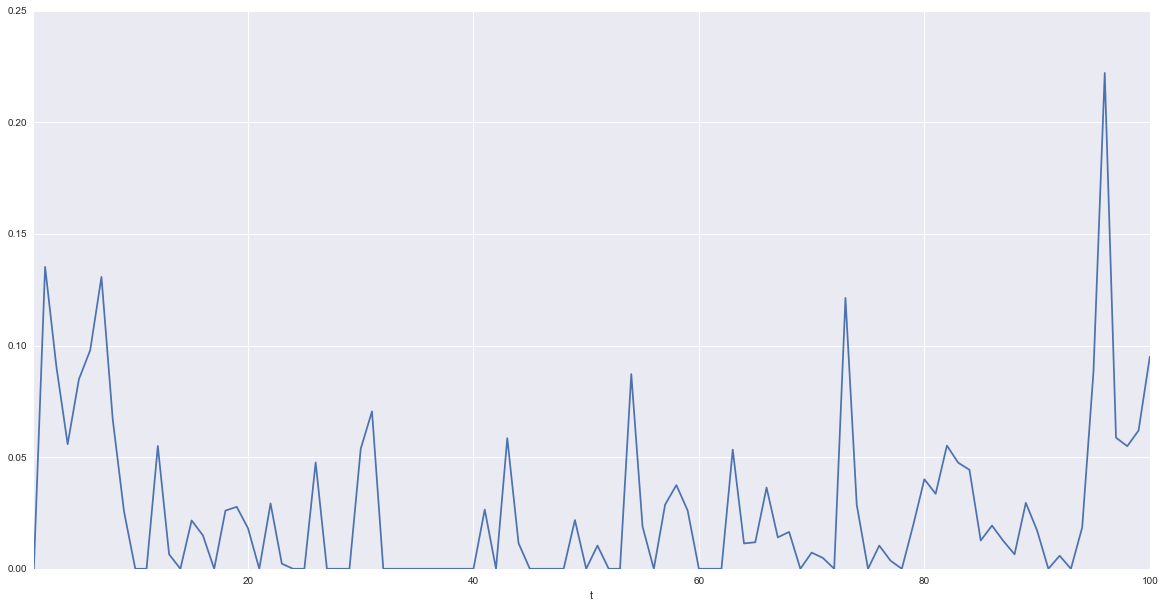

In [48]:
fluc_mat.mean().plot(figsize=(20,10))

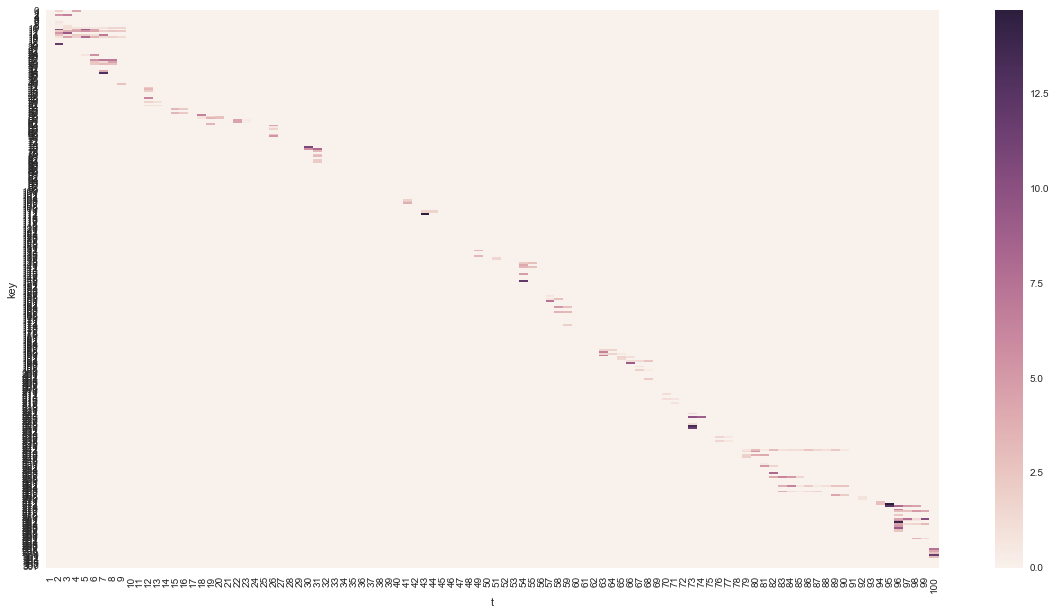

In [29]:
from matplotlib import pyplot as plt
plt.figure(figsize=(20,10))
sns.heatmap(fluc_mat,)

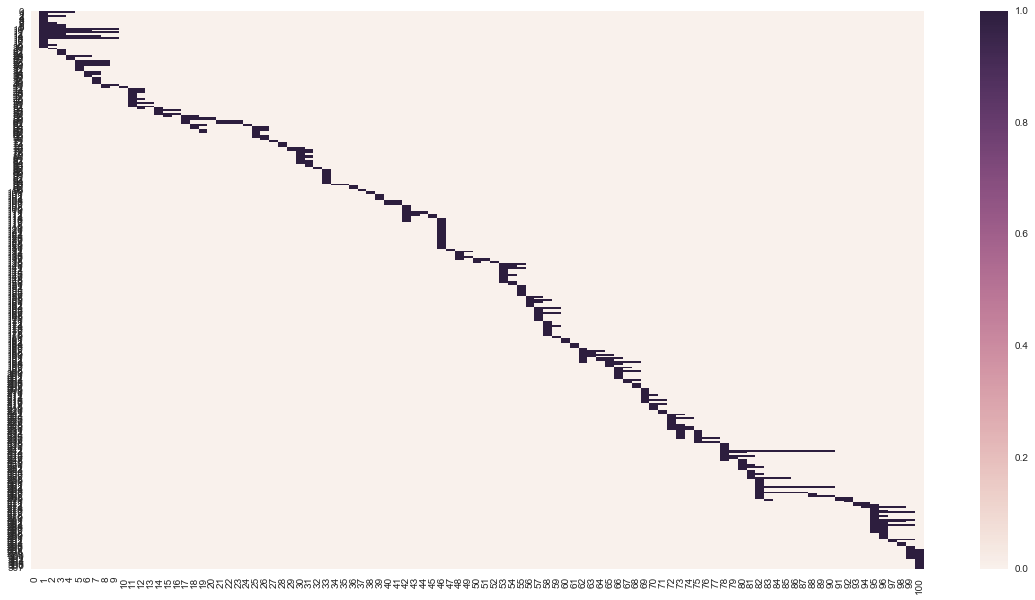

In [36]:
plt.figure(figsize=(20,10))
life_mat_snap = make_life_mat(df[(df.t> 20) &(df.t< 50)])
sns.heatmap(life_mat)

In [81]:
time = life_mat.sum(axis=0).reset_index().drop("index",1)
time.columns = ["alive"]
time["births"] = births.sum()
time["deaths"] = deaths.sum()
time["observed_by_t"] = births.sum().cumsum().astype(int)
time["mean_age_at_t"]  = ageMat.replace(0, np.nan).mean().round(2).fillna(0)
time.index.name = 't'
time = time.reset_index()
time
#time.to_csv("timeseries.csv",index=None)

,t,alive,births,deaths,observed_by_t,mean_age_at_t
0,0,0.0,0.0,0.0,0,0.00
1,1,20.0,20.0,0.0,20,1.00
2,2,13.0,1.0,8.0,21,1.92
3,3,13.0,3.0,3.0,24,2.54
4,4,9.0,3.0,7.0,27,3.00
5,5,12.0,6.0,3.0,33,2.75
6,6,12.0,3.0,3.0,36,3.50
7,7,13.0,4.0,3.0,40,3.46
8,8,8.0,2.0,7.0,42,4.75
9,9,4.0,0.0,4.0,42,7.25


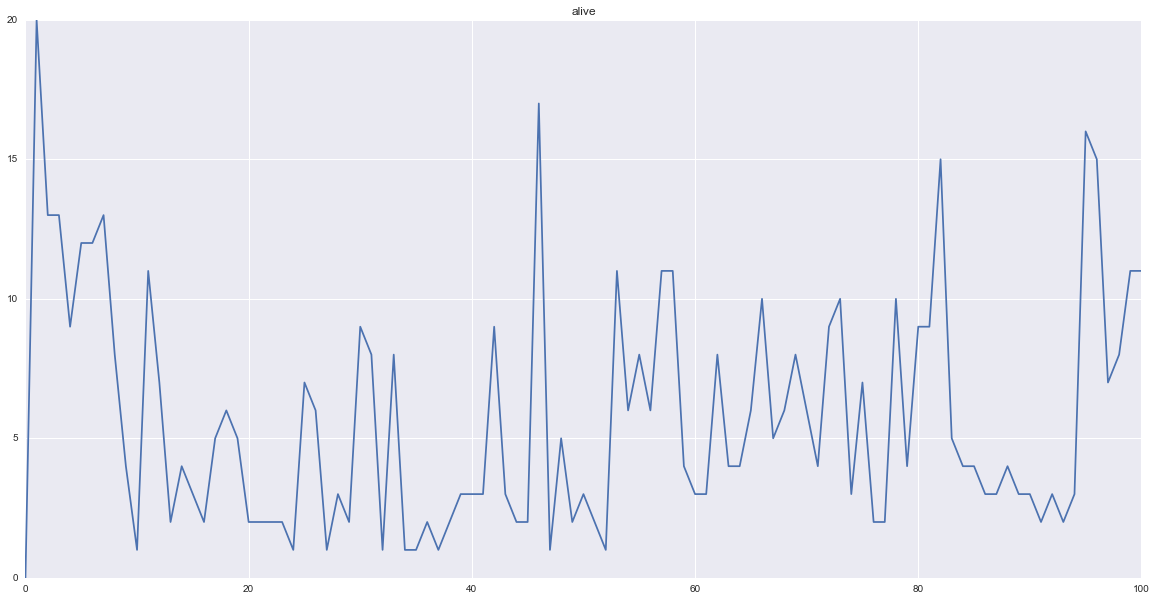

In [39]:
#alive
life_mat.sum(axis=0).plot(title="alive",figsize=(20,10))

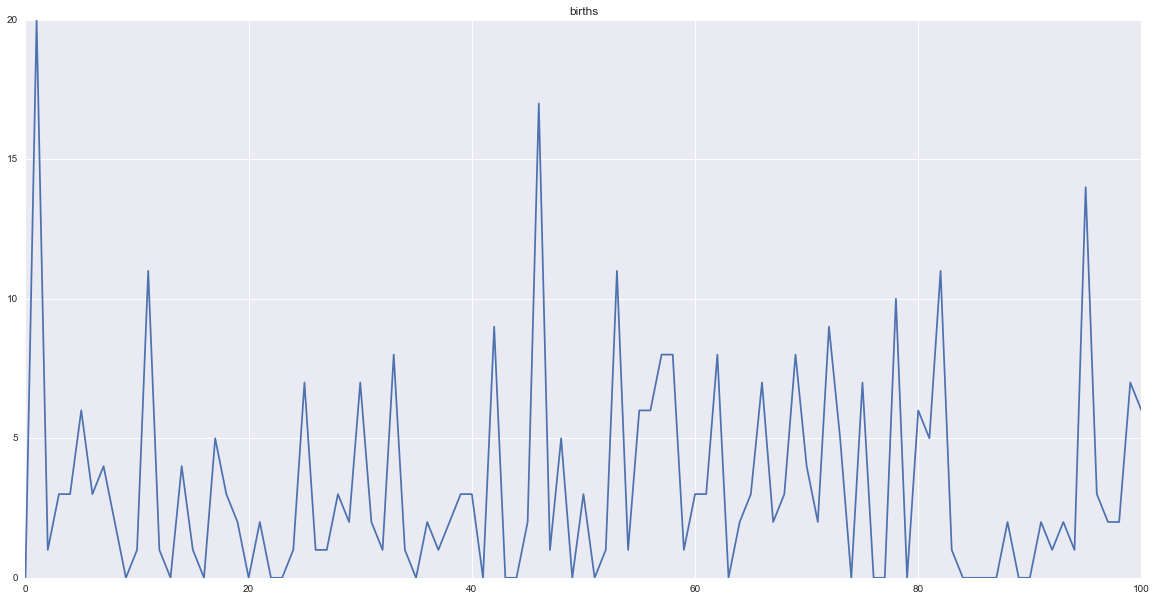

In [40]:
births.sum().plot(title="births",figsize=(20,10))

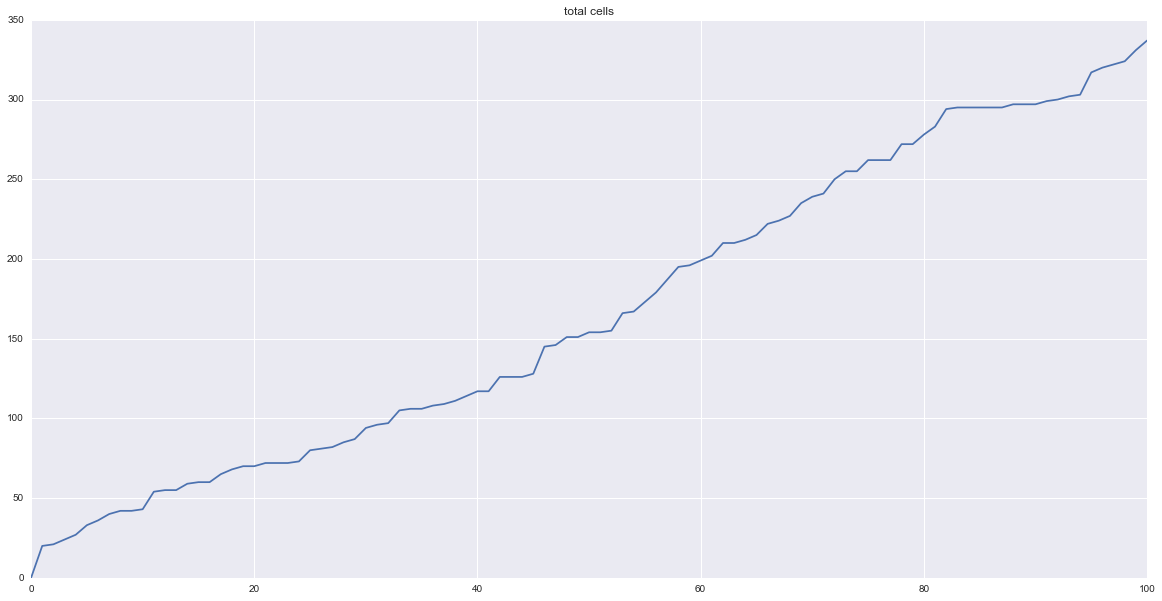

In [43]:
births.sum().cumsum().plot(title="total cells",figsize=(20,10))

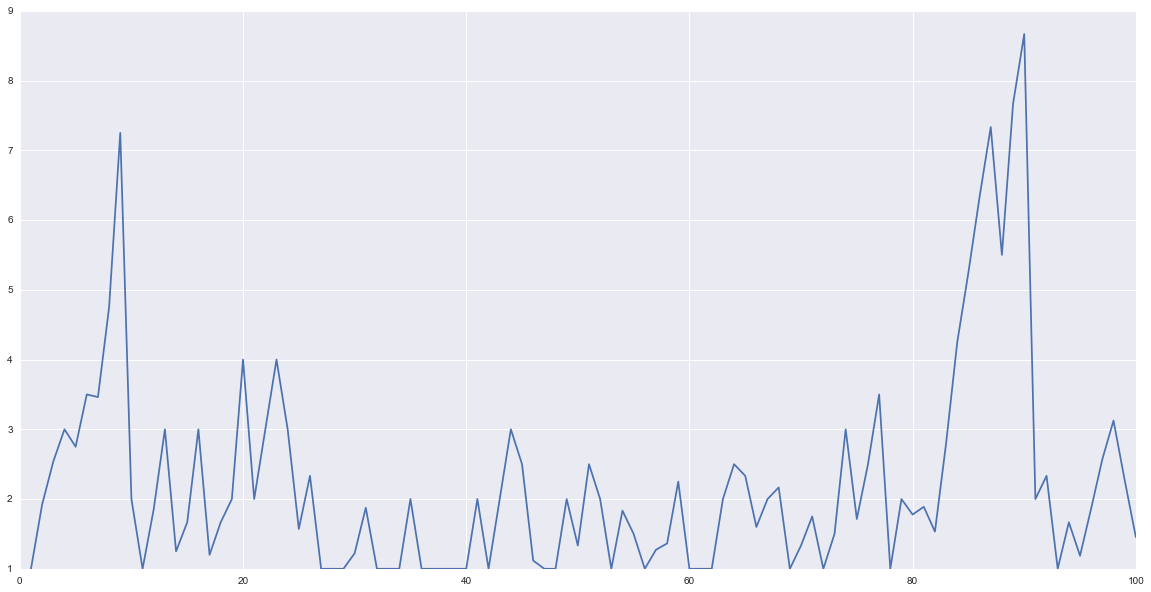

In [44]:
mean_age = ageMat.replace(0, np.nan).mean()
mean_age.plot(figsize=(20,10))